In [1]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model,load_model
from tensorflow.keras import Sequential,models,layers
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.applications.resnet50 import  ResNet50
from tensorflow.keras.applications import VGG16

In [2]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [3]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

# Image Dataset Loading 

In [5]:
train_data = train_df('E:/Danilka/MRI/Training')
test_data = test_df('E:/Danilka/MRI/Testing')
print(train_data)
print("test")
print(test_data)

                                            Class Path      Class
0      E:/Danilka/MRI/Training\glioma\Tr-glTr_0000.jpg     glioma
1      E:/Danilka/MRI/Training\glioma\Tr-glTr_0001.jpg     glioma
2      E:/Danilka/MRI/Training\glioma\Tr-glTr_0002.jpg     glioma
3      E:/Danilka/MRI/Training\glioma\Tr-glTr_0003.jpg     glioma
4      E:/Danilka/MRI/Training\glioma\Tr-glTr_0004.jpg     glioma
...                                                ...        ...
5707  E:/Danilka/MRI/Training\pituitary\Tr-pi_1452.jpg  pituitary
5708  E:/Danilka/MRI/Training\pituitary\Tr-pi_1453.jpg  pituitary
5709  E:/Danilka/MRI/Training\pituitary\Tr-pi_1454.jpg  pituitary
5710  E:/Danilka/MRI/Training\pituitary\Tr-pi_1455.jpg  pituitary
5711  E:/Danilka/MRI/Training\pituitary\Tr-pi_1456.jpg  pituitary

[5712 rows x 2 columns]
test
                                           Class Path      Class
0      E:/Danilka/MRI/Testing\glioma\Te-glTr_0000.jpg     glioma
1      E:/Danilka/MRI/Testing\glioma\Te-glTr_000

# Image View

<>:3: SyntaxWarning: invalid escape sequence '\g'
<>:3: SyntaxWarning: invalid escape sequence '\g'
C:\Users\Danilka\AppData\Local\Temp\ipykernel_588396\212335379.py:3: SyntaxWarning: invalid escape sequence '\g'
  img = cv2.imread("E:/Danilka/MRI/Training\glioma\Tr-glTr_0005.jpg")


E:/Danilka/MRI/Training\glioma\Tr-glTr_0002.jpg
(512, 512, 3)


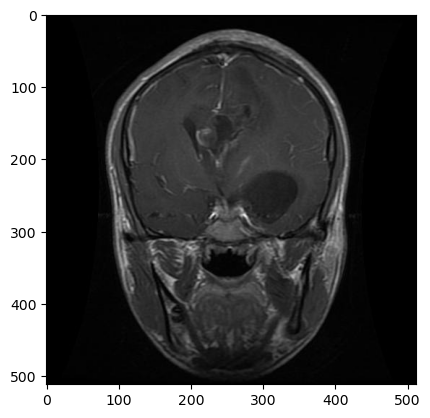

In [6]:
first_class_path = train_data.loc[2, 'Class Path']
print(first_class_path)
img = cv2.imread("E:/Danilka/MRI/Training\glioma\Tr-glTr_0005.jpg")
print(img.shape)
plt.imshow(img)

# Data Preprocessing 


In [6]:
valid_data, test_data = train_test_split(test_data, train_size=0.5, random_state=42, stratify=test_data['Class'])

In [7]:
batch_size = 32
img_size = (255, 255)

data_prep = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

test_data_prep = ImageDataGenerator(rescale=1/255)


train_prep_data = data_prep.flow_from_dataframe(train_data, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size)

valid_prep_data = data_prep.flow_from_dataframe(valid_data, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size)

test_prep_data = test_data_prep.flow_from_dataframe(test_data, x_col='Class Path',
                                  y_col='Class', batch_size=16,
                                  target_size=img_size, shuffle=False)

Found 5712 validated image filenames belonging to 4 classes.


NameError: name 'valid_data' is not defined

# Transfer Learning

In [8]:
img_shape=(255,255,3)
base_model = tf.keras.applications.Xception(include_top= False, weights= "imagenet",
                            input_shape= img_shape, pooling= 'max')

base_model.trainable = False

inputs = Input(shape = img_shape)

x = base_model(inputs)

x = Flatten()(x)

x = Dropout(rate= 0.3)(x)
x = Dense(128, activation= 'relu')(x)
x = Dropout(rate= 0.25)(x)
x = Dense(4, activation= 'softmax')(x)
    
model = Model(inputs, x)

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

In [9]:
hist = model.fit(train_prep_data,
                 epochs=5,
                 validation_data=valid_prep_data,
                 shuffle= False)

NameError: name 'valid_prep_data' is not defined

# Fine Tuning

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

model.compile(Adamax(learning_rate= 0.001),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy',
                        Precision(),
                        Recall()])

history_fine = model.fit(train_prep_data,
                 epochs=5,
                 validation_data=valid_prep_data,
                 shuffle= False)

# VGG 16


In [8]:
vgg_base = VGG16(weights='imagenet',include_top=False,input_shape=(224,224,3))

In [9]:
vgg_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
for layer in vgg_base.layers:
    layer.trainable = False

# Unfreeze the last 8 layers
for layer in vgg_base.layers[-2:]:
    layer.trainable = True

In [11]:
vgg_model = models.Sequential()
vgg_model.add(vgg_base)
vgg_model.add(layers.Flatten())
vgg_model.add(layers.BatchNormalization())
vgg_model.add(layers.Dense(128, activation='relu'))
vgg_model.add(layers.Dropout(0.5))
vgg_model.add(layers.BatchNormalization())
vgg_model.add(layers.Dense(64, activation='relu'))
vgg_model.add(layers.Dropout(0.5))
vgg_model.add(layers.Dense(4, activation='softmax'))

In [12]:
vgg_model.compile(
    optimizer=RMSprop(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [13]:
from tensorflow.keras.utils import to_categorical
image_size_for_vgg=(224,224)
data_prep = ImageDataGenerator(rescale=1/255,
                          brightness_range=(0.8, 1.2))

train_prep_data_vgg = data_prep.flow_from_dataframe(train_data, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=image_size_for_vgg)

valid_prep_data_vgg = data_prep.flow_from_dataframe(valid_data, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=image_size_for_vgg)

batch_images, batch_labels = next(iter(train_prep_data_vgg))
print(f"Images shape: {batch_images.shape}, Labels shape: {batch_labels.shape}")




Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Images shape: (32, 224, 224, 3), Labels shape: (32, 4)


C:\Users\Danilka\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 1171s 7s/step - acc: 0.6105 - loss: 1.0609 - val_acc: 0.8214 - val_loss: 0.5112
Epoch 2/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 1148s 6s/step - acc: 0.8167 - loss: 0.5134 - val_acc: 0.8611 - val_loss: 0.3506
Epoch 3/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 1155s 6s/step - acc: 0.8667 - loss: 0.3872 - val_acc: 0.8931 - val_loss: 0.3022
Epoch 4/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 1153s 6s/step - acc: 0.9060 - loss: 0.2871 - val_acc: 0.9267 - val_loss: 0.1999
Epoch 5/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 1167s 7s/step - acc: 0.9276 - loss: 0.2243 - val_acc: 0.9359 - val_loss: 0.1808
Epoch 6/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 613s 3s/step - acc: 0.9380 - loss: 0.1777 - val_acc: 0.9481 - val_loss: 0.1355
Epoch 7/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 242s 1s/step - acc: 0.9466 - loss: 0.1644 - val_acc: 0.9603 - val_loss: 0.1120
Epoch 8/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - acc: 0.9579 - loss: 0.1347 - val_acc: 0.9664 - val_loss: 0.0997
Epoch 9/15
179/179 ━━━━━━━━━━━━━━━━━━━━ 232

KeyError: 'accuracy'

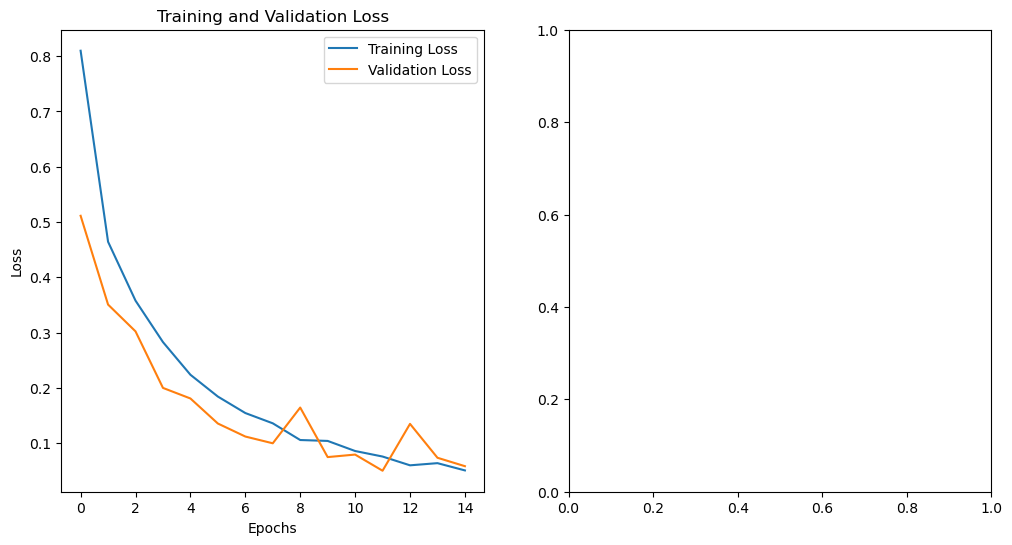

In [14]:
import matplotlib.pyplot as plt

# Fit the model
vgg_his = vgg_model.fit(
    train_prep_data_vgg,  
    epochs=15, 
    validation_data=valid_prep_data_vgg,  
    shuffle=True  
)

# Plotting the loss
plt.figure(figsize=(12, 6))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(vgg_his.history['loss'], label='Training Loss')
plt.plot(vgg_his.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values (optional)
plt.subplot(1, 2, 2)
plt.plot(vgg_his.history['accuracy'], label='Training Accuracy')
plt.plot(vgg_his.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [15]:
vgg_model.save("testTumorModelLatestss2.h5")
import os
print(os.getcwd()) 

C:\Users\Danilka


In [16]:
for layer in vgg_base.layers[-2:]:
    print(layer.name, layer.__class__.__name__)

block5_conv3 Conv2D
block5_pool MaxPooling2D


In [11]:
vgg_model=load_model("testTumorModelLatestss.h5")
vgg16_model = vgg_model.get_layer('vgg16')


# XAI part


In [12]:
last_conv_layer = vgg16_model.get_layer('block5_conv3').name
print(last_conv_layer)

block5_conv3


In [13]:
def get_img_array(img_path, size):
    ## `img` is a PIL image 
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    ## We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array


In [14]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    print(model)
    print(last_conv_layer_name)
    print(model.output)
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        # print(f"Shape of preds: {preds.shape}")  # Debugging output
        # print(f"Preds: {preds.numpy()}")  
        print(f"Shape of preds: {preds.shape}")  # Debugging output
        print(f"last layer output: {last_conv_layer_output.shape}") 
        
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
            pred_index = tf.cast(pred_index, tf.int32) 
        # print(f"Predicted index: {pred_index.numpy()}")    
        class_channel = tf.gather(preds, pred_index, axis=1)
        print(f"Shape of class_channel: {class_channel.shape}") 

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    ## For visualization purpose
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [28]:
img_path ="E:/Danilka/MRI/Training\glioma\Tr-glTr_0003.jpg"   
img_size = (224, 224)  # VGG-16 input size
img_array = get_img_array(img_path, img_size)

heatmap = make_gradcam_heatmap(img_array, vgg16_model, 'block5_conv3')

<>:1: SyntaxWarning: invalid escape sequence '\g'
<>:1: SyntaxWarning: invalid escape sequence '\g'
C:\Users\Danilka\AppData\Local\Temp\ipykernel_588396\136818972.py:1: SyntaxWarning: invalid escape sequence '\g'
  img_path ="E:/Danilka/MRI/Training\glioma\Tr-glTr_0003.jpg"


<Functional name=vgg16, built=True>
block5_conv3
<KerasTensor shape=(None, 7, 7, 512), dtype=float32, sparse=False, name=keras_tensor_175>


C:\Users\Danilka\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


Shape of preds: (1, 7, 7, 512)
last layer output: (1, 14, 14, 512)
Shape of class_channel: (1, 7, 512, 7, 512)


In [23]:
import cv2
import numpy as np



def apply_gradcam(image_path, heatmap, head_mask, alpha=0.5, threshold=0.50):
    # Load the original image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Error loading image: {image_path}")

    # Convert image to RGB (since OpenCV loads as BGR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Resize heatmap and mask to match image size
    processed_heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
    
    head_mask = cv2.resize(head_mask, (image.shape[1], image.shape[0]))
  

    # Normalize heatmap (scale values between 0 and 255)
    processed_heatmap = np.uint8(255 * processed_heatmap)

    # Apply colormap (using JET for stronger visibility)
    heatmap_colored = cv2.applyColorMap(processed_heatmap, cv2.COLORMAP_JET)

    # Threshold: Remove low-activation areas
    heatmap_colored[processed_heatmap < threshold * np.max(processed_heatmap)] = 0

    # Apply the head mask to the heatmap (set everything outside the head area to black)
    heatmap_colored = cv2.bitwise_and(heatmap_colored, heatmap_colored, mask=head_mask)

    # Apply the head mask to the original image (set everything outside the head area to black)
    image_masked = cv2.bitwise_and(image, image, mask=head_mask)

    # Convert heatmap to RGB (as it was changed to BGR after applying colormap)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

    # Blend the masked heatmap with the original masked image
    superimposed_img = cv2.addWeighted(image_masked, 1 - alpha, heatmap_colored, alpha, 0)

    return superimposed_img, processed_heatmap







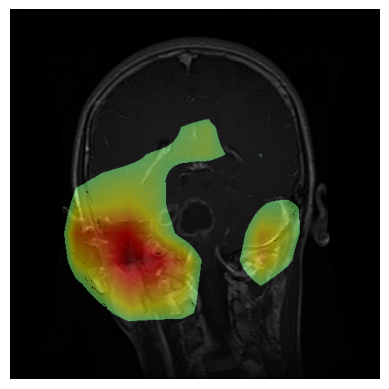

In [29]:
head_mask = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
result,processed_heatmap = apply_gradcam(img_path, heatmap,head_mask)
plt.imshow(result)
plt.axis("off")
plt.show()




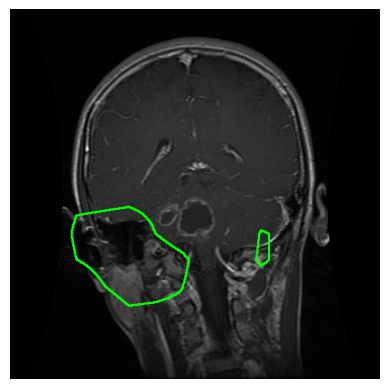

In [30]:

def apply_head_mask(image, head_mask):
    # Ensure that both the image and mask have the same shape
    masked_image = cv2.bitwise_and(image, image, mask=head_mask)
    return masked_image

def segment_heatmap(heatmap, threshold=0.65):
    # Convert heatmap to binary image
    _, binary = cv2.threshold(heatmap, threshold * 255, 255, cv2.THRESH_BINARY)

    # Find contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filter out small contours that likely correspond to the background
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) ]

    return contours

def draw_segmented_contours(image, contours):
    # Draw contours on the image
    contour_img = np.copy(image)
    cv2.drawContours(contour_img, contours, -1, (0, 255, 0), 2)

    return contour_img

image = cv2.imread(img_path)

masked_image = apply_head_mask(image, head_mask)
masked_heatmap = apply_head_mask(processed_heatmap, head_mask)
contours = segment_heatmap(masked_heatmap)
segmented_image = draw_segmented_contours(masked_image, contours)

# Display segmented image
plt.imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [26]:
def segment_tumor_region(heatmap, threshold=0.65):
    """Convert heatmap to binary image and segment tumor region."""
    # Convert heatmap to binary image where values above threshold are foreground
    _, binary = cv2.threshold(heatmap, int(threshold * 255), 255, cv2.THRESH_BINARY)
    
    # Find contours from the binary image
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Optional: filter contours based on area if needed
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 10]  # adjust threshold as needed
    return contours, binary

def extract_tumor_details(contours):
    """Extract geometric details for each detected tumor contour."""
    details = []
    for i, cnt in enumerate(contours):
        # Compute bounding box for the contour
        x, y, w, h = cv2.boundingRect(cnt)
        
        # Compute contour area
        area = cv2.contourArea(cnt)
        
        # Compute centroid of the contour
        M = cv2.moments(cnt)
        if M["m00"] != 0:
            centroid_x = int(M["m10"] / M["m00"])
            centroid_y = int(M["m01"] / M["m00"])
        else:
            centroid_x, centroid_y = 0, 0
        
        details.append({
            "Contour": i,
            "Bounding_Box_X": x,
            "Bounding_Box_Y": y,
            "Width": w,
            "Height": h,
            "Area": area,
            "Centroid_X": centroid_x,
            "Centroid_Y": centroid_y
        })
    return details

In [31]:
contours, binary_tumor_mask = segment_tumor_region(processed_heatmap, threshold=0.65)

# Extract detailed measurements of the tumor contours
tumor_details = extract_tumor_details(contours)

# Convert the details to a DataFrame for easy reporting
df_details = pd.DataFrame(tumor_details)
print("Extracted Tumor Details:")
print(df_details)

Extracted Tumor Details:
   Contour  Bounding_Box_X  Bounding_Box_Y  Width  Height     Area  \
0        0             340             306     19      50    672.5   
1        1              85             273    163     138  14847.5   

   Centroid_X  Centroid_Y  
0         349         330  
1         164         340  


In [19]:
# Predict
predictions = vgg_model.predict(img_array)

# Get class index with highest probability
predicted_class_index = np.argmax(predictions, axis=1)[0]

# Print results
print(f"Predicted Class Index: {predicted_class_index}")
print(f"Class Probabilities: {predictions}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 603ms/step
Predicted Class Index: 1
Class Probabilities: [[2.9510079e-02 5.9315330e-01 6.0431704e-09 3.7733659e-01]]


In [ ]:
class_labels = train_prep_data_vgg.class_indices  # Dictionary of class labels
print(class_labels) 